# Fit CatBoost model using extended features

- Takes the model input data for flight delays
- Split data based on external train/test data file
- Define catboost model
- Perform randomized search on selected parameter space
- Retrain model for more iterations using optimal parameters
- Save model as pickle
- -- save to mlflow -- 
- Write prediction prediction output to csv

### Parameters

-------------------

- input_file: Filepath of model input data of flight delays
- train_test_file: Filepath of train/test csv file with columns ["id", "model_set"]
- output_file: Filepath to write output csv file with minimal modelling input


### Returns

-----------------

Trained baseline model that simply predicts the average flight delay from the training
data in all predictions.


In [2]:
# model params
input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_extended_input.csv"
train_test_file = "../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__timeseries.csv"
output_predictions = "./predictions.csv"

# mlflow params
log_mlflow = True
mlflow_tracking_uri = "../mlruns"
mlflow_experiment = "from_script"
mlflow_run = "catboost_simple"

In [3]:
from pathlib import Path
output_dir = Path(output_predictions).parent.absolute()
output_dir

WindowsPath('C:/Users/lodew/qualogy/schiphol-code-assignment/scripts')

### Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# catboost
from catboost import Pool
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")

from src.data.google_storage_io import read_csv_data, write_csv_data
from src.evaluation.metrics import get_regression_metrics
from src.evaluation.regression import make_regression_metrics_by_group, make_regression_metrics_by_datetime
from src.evaluation.predictions import make_predictions_dataframe

In [5]:
plt.rcParams["figure.figsize"] = (16, 8)

### Read data

In [6]:
%%time
df = read_csv_data(input_file)
train_test = read_csv_data(train_test_file)

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_extended_input.csv

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__timeseries.csv

Wall time: 1.51 s


In [7]:
%%time

def split_train_test(df, train_test, target="scheduleDelaySeconds"):
    # merge by `id` and group by train/test set labels
    df_set_groups = pd.merge(df, train_test, on="id", how="left").groupby("model_set")
    
    # get data per train/test set
    df_train = df_set_groups.get_group("train").drop(columns="model_set")
    df_test = df_set_groups.get_group("test").drop(columns="model_set")
    
    # split target from features
    X_train, y_train = df_train.drop(columns=[target]), df_train[target]
    X_test, y_test = df_test.drop(columns=[target]),  df_test[target]
    
    print(f"""
        Split data shapes
        Input: {df.shape}
        Train: {X_train.shape},\t {y_train.shape} 
        Test:  {X_test.shape},\t {y_test.shape}
        """)
    
    # assert that we haven't dropped values at this stage
    # failed assert could indicate duplicate ids found in the data
    assert (len(X_train) + len(X_test)) == len(df)
    
    return X_train, X_test, y_train, y_test

# split data
X_train, X_test, y_train, y_test = split_train_test(df, train_test)




        Split data shapes
        Input: (487714, 24)
        Train: (389439, 23),	 (389439,) 
        Test:  (98275, 23),	 (98275,)
        
Wall time: 1.1 s


## Prediction model

### Define model

In [8]:
class CatBoostChain(BaseEstimator, TransformerMixin):
    """
    Catboost estimator that uses .transform() to append output predictions
    """
    def __init__(self, catboost_kwargs, early_stopping_rounds=None):
        self.catboost = CatBoostRegressor(**catboost_kwargs)
        self.early_stopping_rounds = early_stopping_rounds
        
    def fit(self, X, y, **kwargs):
        """
        Expects 'y' to be the race finish times- not avg_speed_left
        """
        # calculate avg speed left
        y =  ((X["distance"] - X["Passed"]) / (y.values - X["seconds"])) \
            .replace([np.inf, -np.inf], np.nan) \
            .fillna(0).values
    
        X_pool_train, X_pool_eval, y_pool_train, y_pool_eval = train_test_split(X, y, test_size=0.2)

        train_pool = Pool(data=X_pool_train,
                          label=y_pool_train,
                          cat_features=self.catboost.get_param("cat_features"))
#                                   baseline=X_dist_train["yhat_finish_time"])

        eval_pool = Pool(data=X_pool_eval,
                         label=y_pool_eval,
                         cat_features=self.catboost.get_param("cat_features"))
        
        self.catboost.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=self.early_stopping_rounds, **kwargs)
        
        return self

### Select features for catboost model



In [9]:
columns_to_drop = ["id", "scheduleDateTime", "actualOffBlockTime", "year", "month", "quarter"]
X_train_meta = X_train[["id", "scheduleDateTime"]]
X_test_meta = X_test[["id", "scheduleDateTime"]]

X_train = X_train[[col for col in X_train.columns if col not in columns_to_drop]]
X_test = X_test[[col for col in X_test.columns if col not in columns_to_drop]]

# type categorical features for catboost
cat_features = [
    'aircraftRegistration', 'airlineCode', 'terminal', 'serviceType',
    'final_destination', 'Country', 'City', 'DST',
    'dayofweek', 'dayofmonth', 'weekofyear', 'hour', 'minutes'
]

X_train[cat_features] = X_train[cat_features].astype(str).astype('category')
X_test[cat_features] = X_test[cat_features].astype(str).astype('category')

assert all(X_test.columns == X_train.columns)

X_train.columns

Index(['aircraftRegistration', 'airlineCode', 'terminal', 'serviceType',
       'final_destination', 'Country', 'City', 'Latitude', 'Longitude',
       'Altitude', 'DST', 'destination_distance', 'dayofweek', 'dayofmonth',
       'weekofyear', 'hour', 'minutes'],
      dtype='object')

### Perform random search for optimal parameters

- Random search over grid search for faster results

In [10]:
# create catboost input data
X_pool_train, X_pool_eval, y_pool_train, y_pool_eval = train_test_split(X_train, y_train, test_size=0.2)

train_pool = Pool(data=X_pool_train,
                  label=y_pool_train,
                  cat_features=cat_features)

eval_pool = Pool(data=X_pool_eval,
                 label=y_pool_eval,
                 cat_features=cat_features)

# set initial catboost kwargs for random search
catboost_kwargs={
        "verbose": 1, 
        "iterations": 10,
        "depth": 4,
        "learning_rate": 1,
        "loss_function": "MAE",
        "l2_leaf_reg": 4,
        "train_dir": str(Path(output_dir, "catboost_random_search")),
        "cat_features": cat_features}

# sensible values for random search after trial-error
grid = {'learning_rate': [0.1, 0.3, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
search_model = CatBoostRegressor(**catboost_kwargs)
randomized_search_result = search_model.randomized_search(grid,
                                                   X=train_pool,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 804.7577782
bestIteration = 9

0:	loss: 804.7577782	best: 804.7577782 (0)	total: 953ms	remaining: 8.57s

bestTest = 763.8192678
bestIteration = 9

1:	loss: 763.8192678	best: 763.8192678 (1)	total: 1.7s	remaining: 6.79s

bestTest = 757.4576161
bestIteration = 9

2:	loss: 757.4576161	best: 757.4576161 (2)	total: 2.42s	remaining: 5.64s

bestTest = 763.8192678
bestIteration = 9

3:	loss: 763.8192678	best: 757.4576161 (2)	total: 3.13s	remaining: 4.69s

bestTest = 757.4576161
bestIteration = 9

4:	loss: 757.4576161	best: 757.4576161 (2)	total: 3.85s	remaining: 3.85s

bestTest = 763.8192678
bestIteration = 9

5:	loss: 763.8192678	best: 757.4576161 (2)	total: 4.59s	remaining: 3.06s

bestTest = 757.4576161
bestIteration = 9

6:	loss: 757.4576161	best: 757.4576161 (2)	total: 5.29s	remaining: 2.27s

bestTest = 800.7015278
bestIteration = 9

7:	loss: 800.7015278	best: 757.4576161 (2)	total: 6.15s	remaining: 1.54s

bestTest = 756.1623348
bestIteration = 9

8:	loss: 756.1623348	best: 756

### Train model

In [11]:
# update catboost parameters with randomized search results
updated_catboost_kwargs = dict(
    catboost_kwargs,
    iterations = 200,
    train_dir = str(output_dir),
    **randomized_search_result['params'])

# create new catboost object with updated parameters
model = CatBoostRegressor(**updated_catboost_kwargs)
# train final model
model.fit(train_pool, eval_set = eval_pool, early_stopping_rounds=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 756.4992915	test: 736.1896539	best: 736.1896539 (0)	total: 486ms	remaining: 1m 36s
1:	learn: 716.4095588	test: 689.1406306	best: 689.1406306 (1)	total: 1.01s	remaining: 1m 40s
2:	learn: 697.8411741	test: 668.3668963	best: 668.3668963 (2)	total: 1.27s	remaining: 1m 23s
3:	learn: 692.7714155	test: 663.3020848	best: 663.3020848 (3)	total: 1.63s	remaining: 1m 19s
4:	learn: 678.4410044	test: 645.9118846	best: 645.9118846 (4)	total: 2.06s	remaining: 1m 20s
5:	learn: 665.8758141	test: 631.6815334	best: 631.6815334 (5)	total: 2.36s	remaining: 1m 16s
6:	learn: 659.9978535	test: 624.8699020	best: 624.8699020 (6)	total: 2.82s	remaining: 1m 17s
7:	learn: 657.8774503	test: 622.9807212	best: 622.9807212 (7)	total: 3.06s	remaining: 1m 13s
8:	learn: 655.4896950	test: 620.3435796	best: 620.3435796 (8)	total: 3.36s	remaining: 1m 11s
9:	learn: 653.2327483	test: 618.2358122	best: 618.2358122 (9)	total: 3.6s	remaining: 1m 8s
10:	learn: 651.1965779	test: 616.2311812	best: 616.2311812 (10)	total: 3

### Evaluate model

In [12]:
def datetime_to_date(dt):
    return pd.to_datetime(dt, utc=True).dt.date

def datetime_to_date_hour(dt):
    return pd.to_datetime(dt, utc=True).dt.floor('H')


In [13]:
# create predictions on train/test sets
df_predictions = make_predictions_dataframe(model, X_train, X_test, y_train, y_test,
                                           meta_train = X_train_meta,
                                           meta_test = X_test_meta)
df_predictions

id           scheduleDateTime       y        yhat  \
0       123414481790510775  2018-01-01 03:30:00+01:00  -480.0 -197.459328   
1       123414479288269149  2018-01-01 06:00:00+01:00   -98.0 -100.360379   
2       123414479666542945  2018-01-01 06:05:00+01:00  -300.0 -120.601478   
3       123414479288365061  2018-01-01 06:05:00+01:00  -300.0 -121.494374   
4       123414479288274329  2018-01-01 06:15:00+01:00   694.0  176.538920   
...                    ...                        ...     ...         ...   
487709  124763270719624901  2018-07-12 17:25:00+02:00    80.0  280.244578   
487710  124763272032451639  2018-07-12 17:25:00+02:00    80.0  281.817452   
487711  124763270368084713  2018-07-12 17:25:00+02:00    12.0  278.095160   
487712  124763270625998761  2018-07-12 17:45:00+02:00 -1935.0   -2.120094   
487713  124763271129903067  2018-07-12 17:50:00+02:00 -8690.0   31.526172   

              error model_set  
0        282.540672     train  
1         -2.360379     train  
2        179.398522     train  
3        178.505626     train  
4       -517.461080     train  
...             ...       ...  
487709   200.244578      test  
487710   201.817452      test  
487711   266.095160      test  
487712  1932.879906      test  
487713  8721.526172      test  

[487714 rows x 6 columns]

#### Calculate regression metrics

In [14]:
%%time

df_metrics_long = make_regression_metrics_by_group(df_predictions, group_cols = ["model_set"])
df_daily_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="D", alias="schedule_date")
df_hourly_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="H", alias="schedule_date")

Wall time: 9.12 s


In [15]:
df_metrics_long.head()

model_set variable        value
0      test      mae   841.293334
1     train      mae   558.490217
2      test     mape   365.325530
3     train     mape   448.172767
4      test     rmse  2429.517313

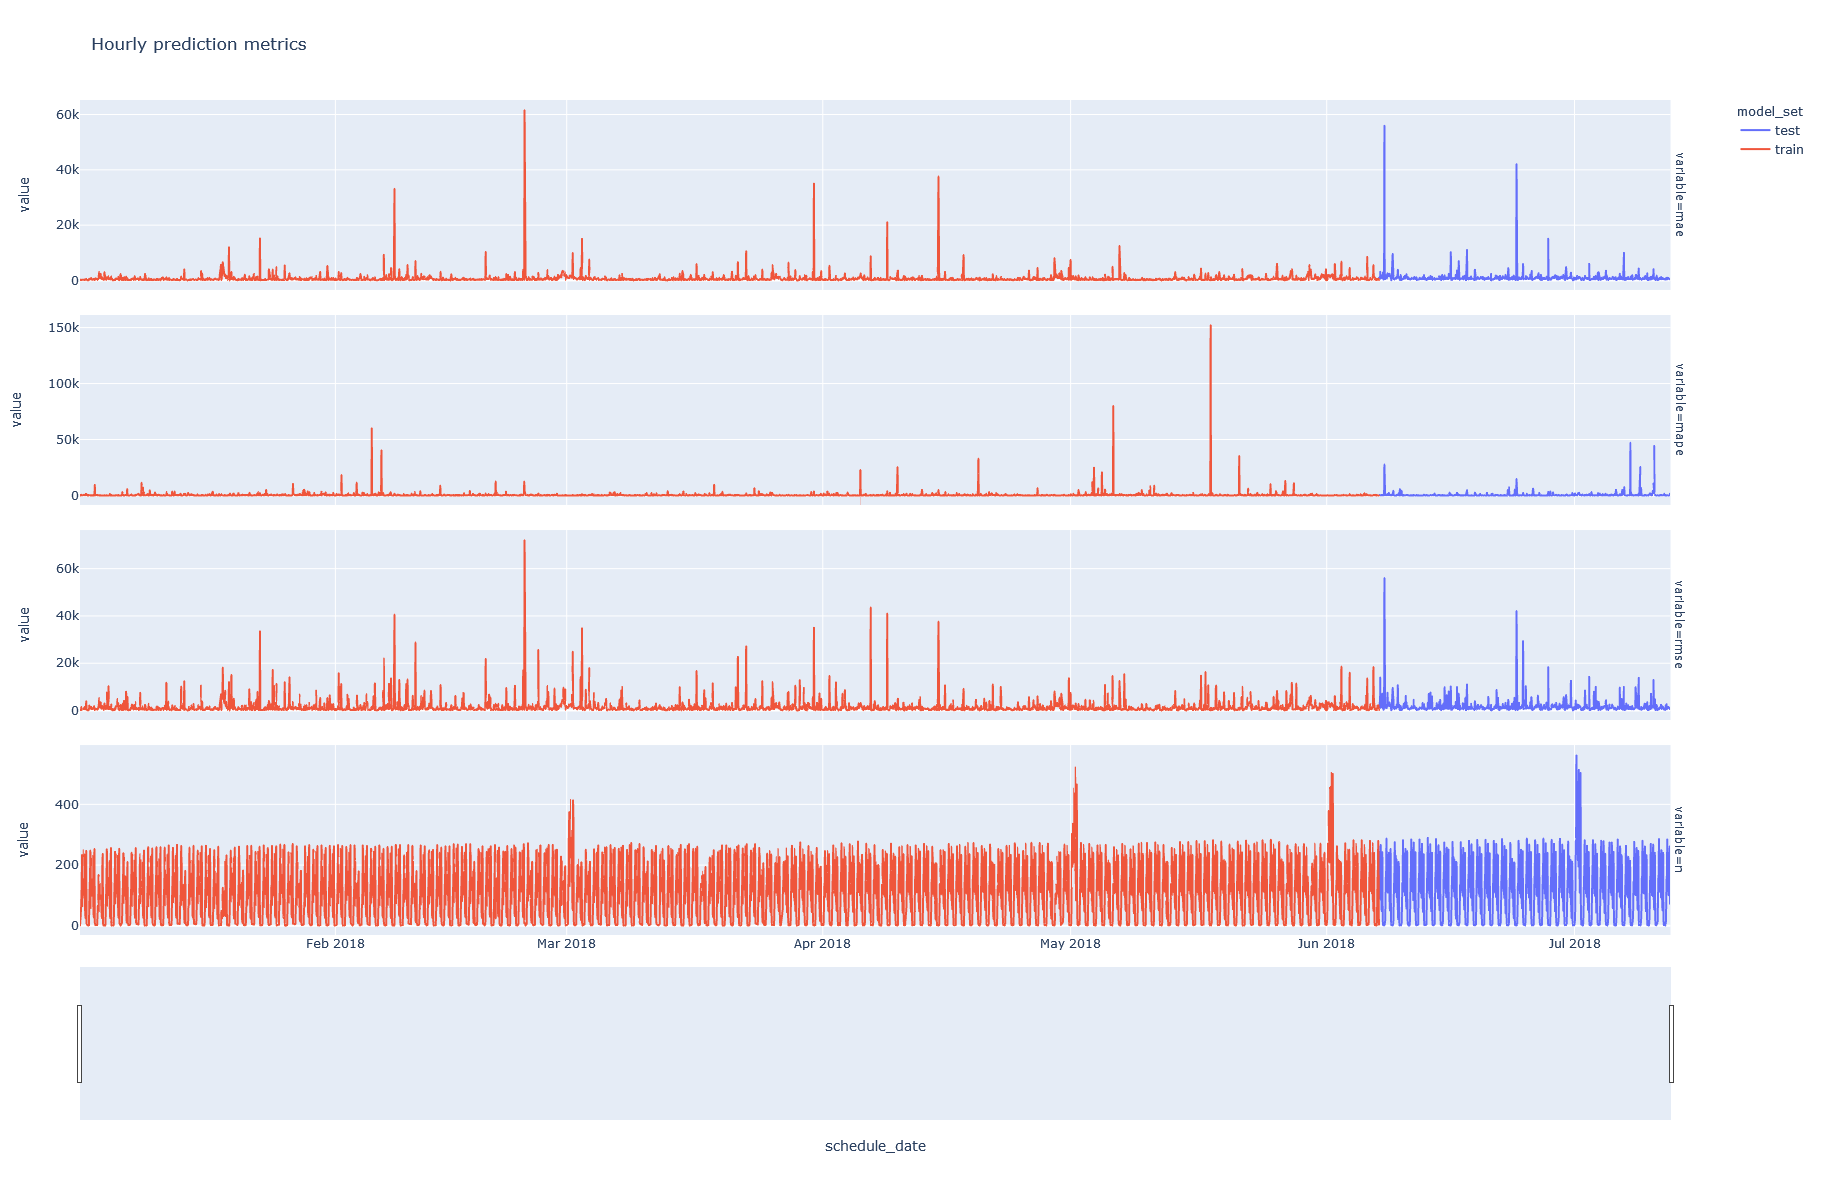

In [16]:
import plotly.express as px
fig = px.line(df_hourly_metrics_long, x="schedule_date", y="value", facet_row="variable", color="model_set",
             width=1200, height=1200, title="Hourly prediction metrics")
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    hovermode="x"
)
fig.update_yaxes(matches=None)
# fig.update_xaxes(matches=None)
fig.show()

## Plot some prediction results

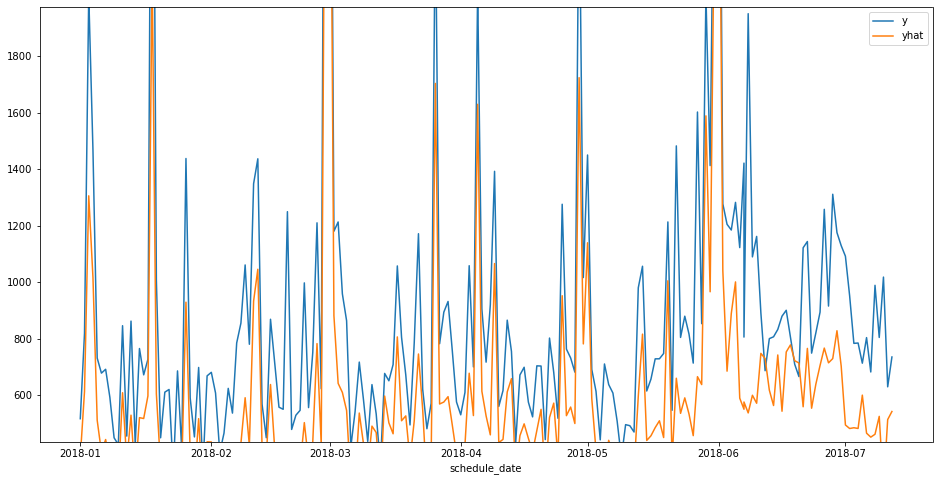

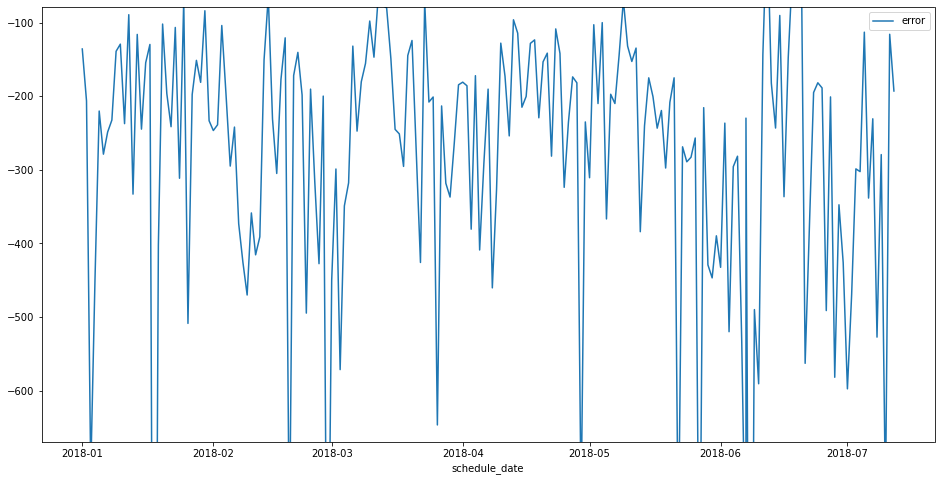

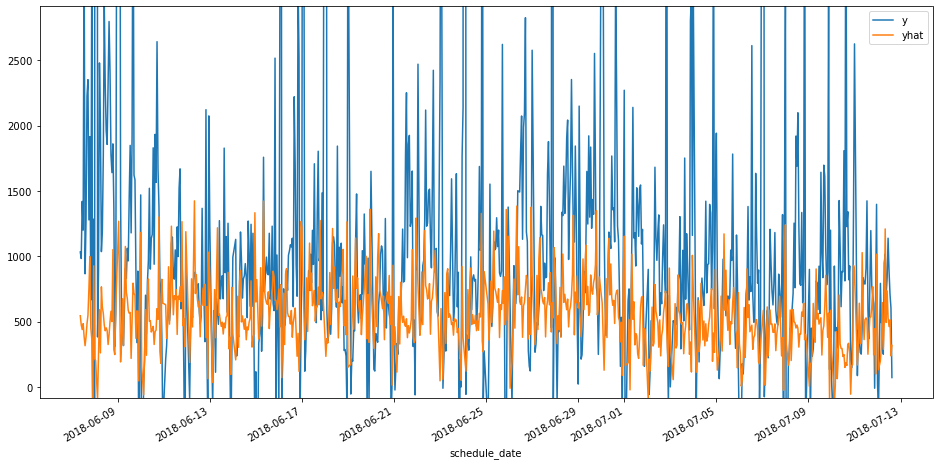

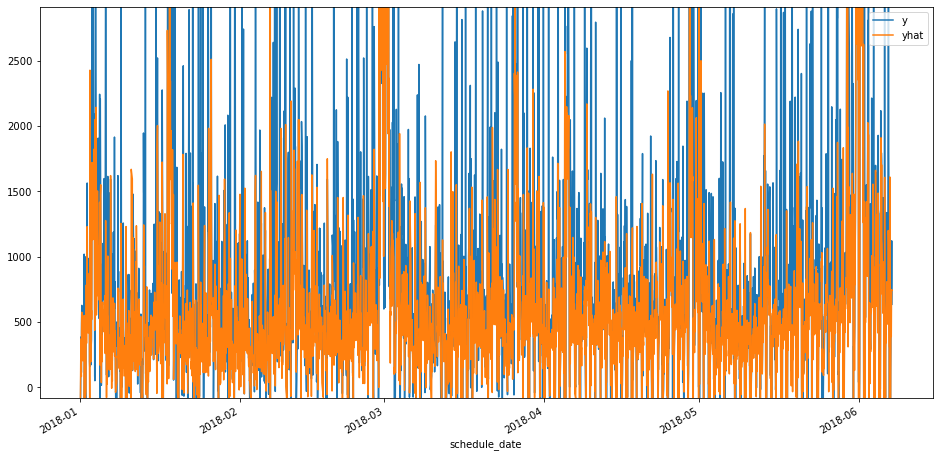

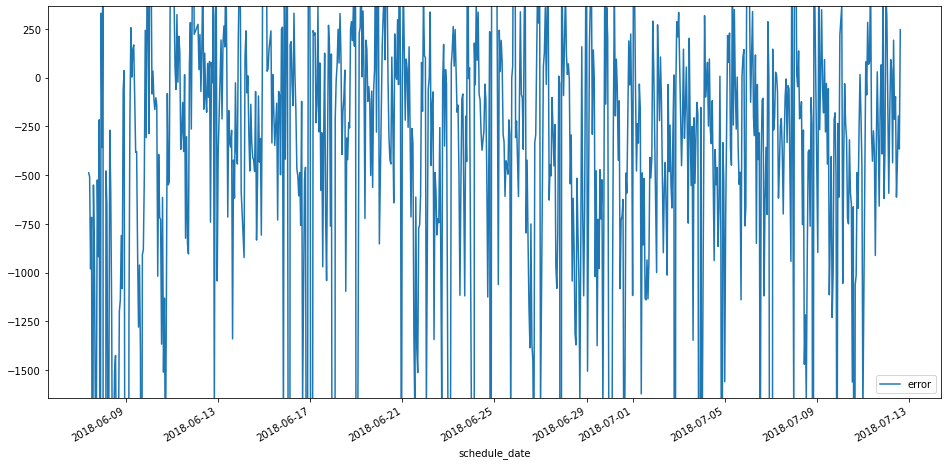

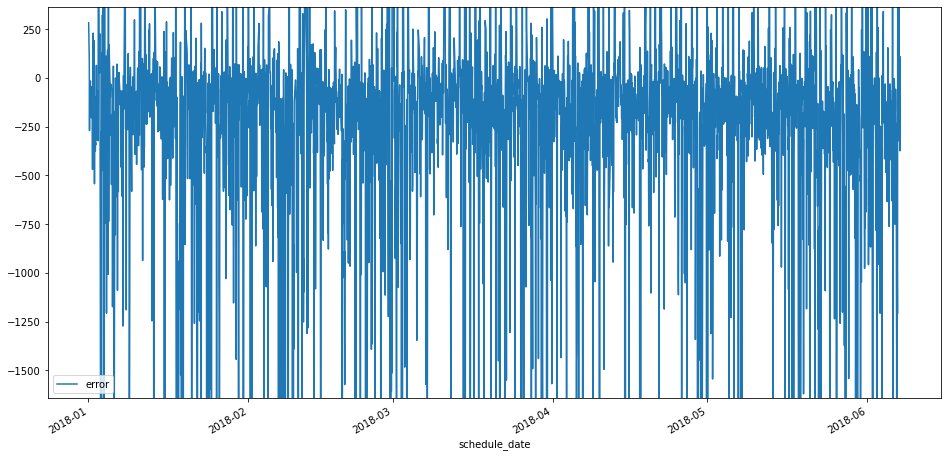

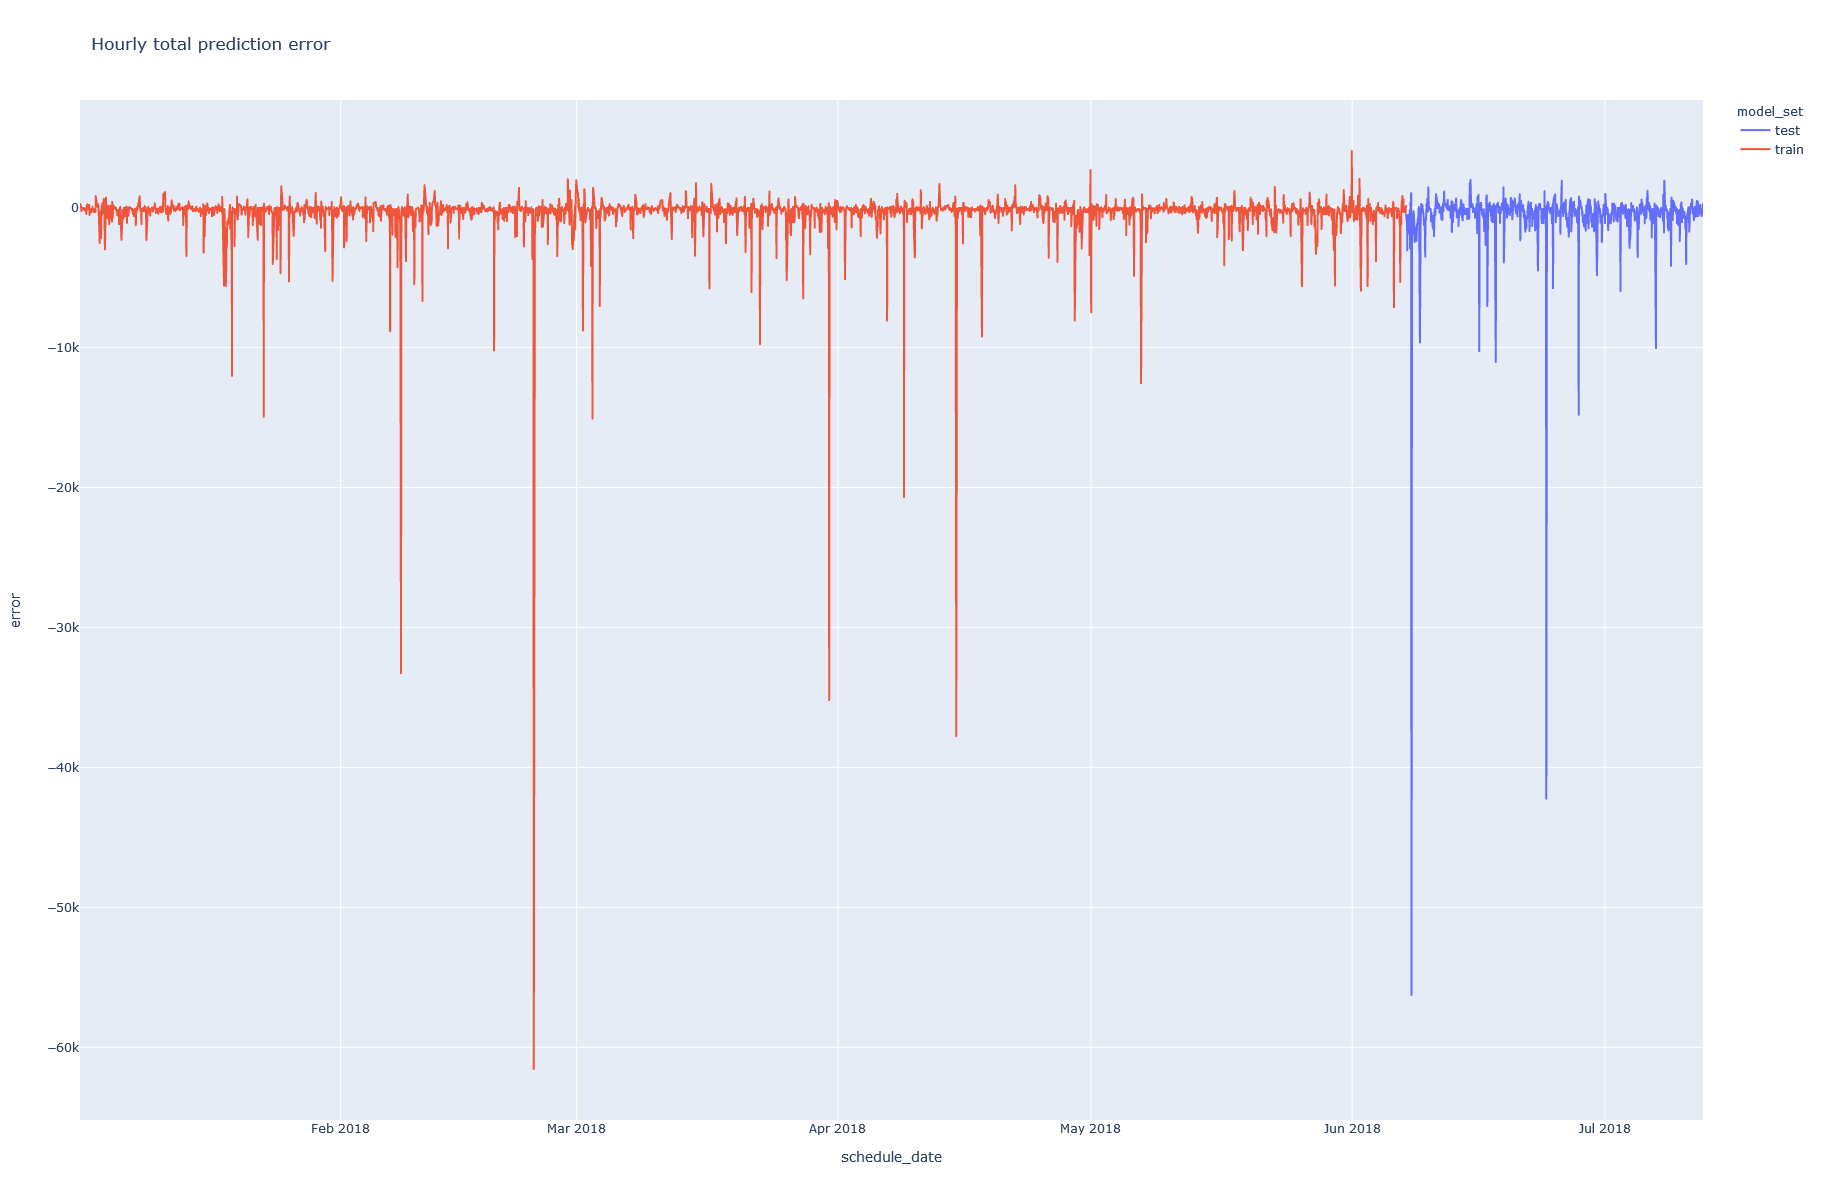

In [17]:
def predictions_daily_mean(df_predictions):
    df_predictions["schedule_date"] = datetime_to_date(df_predictions["scheduleDateTime"])
    df_predictions = df_predictions.drop(columns="id")
    df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
    return df_daily_mean

def predictions_hourly_mean(df_predictions):
    df_predictions["schedule_date"] = datetime_to_date_hour(df_predictions["scheduleDateTime"])
    df_predictions = df_predictions.drop(columns="id")
    df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
    return df_daily_mean

def get_safe_ylim(y, q=0.05, q2=None):
    if q2 is None:
        q2 = 1 - q
    return (np.quantile(y, q), np.quantile(y, q2))


df_daily_mean = predictions_daily_mean(df_predictions)
y_ylim = get_safe_ylim(df_daily_mean["y"])
error_ylim = get_safe_ylim(df_daily_mean["error"])

df_daily_mean[["schedule_date", "y", "yhat", "model_set"]].plot(x="schedule_date", ylim=y_ylim)
df_daily_mean[["schedule_date", "error", "model_set"]].plot(x="schedule_date", ylim=error_ylim)

df_hourly_mean = predictions_hourly_mean(df_predictions)
y_ylim = get_safe_ylim(df_hourly_mean["y"])
error_ylim = get_safe_ylim(df_hourly_mean["error"])

df_hourly_mean[["schedule_date", "y", "yhat", "model_set"]].groupby("model_set").plot(x="schedule_date", ylim=y_ylim)
df_hourly_mean[["schedule_date", "error", "model_set"]].groupby("model_set").plot(x="schedule_date", ylim=error_ylim)

df_hourly_mean[["schedule_date", "y", "yhat", "error", "model_set"]]
plt.show()

fig = px.line(df_hourly_mean, x="schedule_date", y="error", color="model_set",
             width=1200, height=1200, title="Hourly total prediction error")
fig.update_yaxes(matches=None)
fig.update_xaxes(matches=None)
fig.show()

### Write output to output directory

In [18]:
import joblib, pickle
from pathlib import Path

In [ ]:
model_file = str(Path(output_dir, "model.pkl"))
predictions_file = str(Path(output_dir, "predictions.csv"))
overall_metrics_file = str(Path(output_dir, "overall_metrics_long.csv"))
daily_metrics_file = str(Path(output_dir, "daily_metrics_long.csv"))
hourly_metrics_file = str(Path(output_dir, "hourly_metrics_long.csv"))

## Pickle output files for mlflow artifacts

- Pipeline serialized with `joblib`
- Model data or sample thereof 



In [19]:
joblib.dump(model, Path(output_dir, model_file))

['C:\\Users\\lodew\\qualogy\\schiphol-code-assignment\\scripts\\model.pkl']

## Write output to CSV

Local or Google Storage is both handled

In [20]:
# write output file
write_csv_data(df_predictions,       predictions_file, index=False)
write_csv_data(df_metrics_long,       overall_metrics_file, index=False)
write_csv_data(df_daily_metrics_long, daily_metrics_file, index=False)
write_csv_data(df_hourly_metrics_long, hourly_metrics_file, index=False)

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\predictions.csv

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\overall_metrics_long.csv

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\daily_metrics_long.csv

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\hourly_metrics_long.csv



### Log to MLFlow

In [21]:
import mlflow

mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(mlflow_experiment)

print(f"Logging to experiment: {mlflow_experiment}")
print(f"Run name: {mlflow_run}")

with mlflow.start_run(run_name=mlflow_run):
    mlflow.log_param("Input file", input_file)
    mlflow.log_param("Train-test file", train_test_file)
    
    # Model metadata
    for idx, metric_row in df_metrics_long.iterrows():
        metric_name = "__".join([metric_row["variable"], metric_row["model_set"]])
        mlflow.log_metric(metric_name, metric_row["value"])
    
    # log artifacts
    print("Logging artifacts")
    mlflow.log_artifact(predictions_file)
    mlflow.log_artifact(overall_metrics_file)
    mlflow.log_artifact(daily_metrics_file)
    mlflow.log_artifact(hourly_metrics_file)
    


INFO: 'from_script' does not exist. Creating a new experiment
Logging to experiment: from_script
Run name: catboost_simple
Logging artifacts


NameError: name 'predictions_file' is not defined

### Overview of the output data

In [ ]:
df_predictions.info()